In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/walmart-sales-forecast/features.csv
/kaggle/input/walmart-sales-forecast/stores.csv
/kaggle/input/walmart-sales-forecast/train.csv
/kaggle/input/walmart-sales-forecast/test.csv


# Description
Task 7:  Sales Forecasting Description
 
 Description:
 * Dataset (Recommended): Walmart Sales Forecast (Kaggle)
 * Predict future sales based on historical sales data
 * Create time-based features (day, month, lag values)
 * Apply regression models to forecast next period's sales
 * Plot actual vs. predicted values over time
 
 Tools & Libraries:
 Python
 Pandas
 Matplotlib
 Scikit-learn
 
 Covered Topics:
 Time series forecasting |  Regression
 
 Bonus:
 Use rolling averages and seasonal decomposition.
Apply XGBoost or LightGBM with time-aware validation

# Import Libraries

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Load Dataset

In [21]:
features = pd.read_csv("/kaggle/input/walmart-sales-forecast/features.csv")
stores = pd.read_csv("/kaggle/input/walmart-sales-forecast/stores.csv")
train = pd.read_csv("/kaggle/input/walmart-sales-forecast/train.csv")
test = pd.read_csv("/kaggle/input/walmart-sales-forecast/test.csv")

In [26]:
print("Features Dataset shape:", features.shape)
features.head()

Features Dataset shape: (8190, 12)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [27]:
print("Stores Dataset shape:", stores.shape)
stores.head()

Stores Dataset shape: (45, 3)


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [28]:
print("Train Dataset shape:", train.shape)
train.head()

Train Dataset shape: (421570, 5)


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [29]:
print("Test Dataset shape:", test.shape)
test.head()

Test Dataset shape: (115064, 4)


,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


## Convert Date to datetime

In [30]:
# Convert Date to datetime
for df in [features, train, test]:
    df["Date"] = pd.to_datetime(df["Date"])

# Merge datasets

In [31]:
train = train.merge(features, on=["Store", "Date", "IsHoliday"], how="left")
train = train.merge(stores, on="Store", how="left")

test = test.merge(features, on=["Store", "Date", "IsHoliday"], how="left")
test = test.merge(stores, on="Store", how="left")

# Feature engineering: extract time features

In [32]:
def create_time_features(df):
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["Week"] = df["Date"].dt.isocalendar().week.astype(int)
    df["Day"] = df["Date"].dt.day
    return df

train = create_time_features(train)
test = create_time_features(test)

# Lag features and rolling averages (per Store-Dept)

In [33]:
train = train.sort_values(["Store", "Dept", "Date"])
train["Lag_1"] = train.groupby(["Store", "Dept"])["Weekly_Sales"].shift(1)
train["Lag_2"] = train.groupby(["Store", "Dept"])["Weekly_Sales"].shift(2)
train["Lag_3"] = train.groupby(["Store", "Dept"])["Weekly_Sales"].shift(3)
train["Rolling_3"] = train.groupby(["Store", "Dept"])["Weekly_Sales"].shift(1).rolling(3).mean()

train = train.dropna()

# Define features and target

In [34]:
target = "Weekly_Sales"
drop_cols = ["Date", "Weekly_Sales"]
X = train.drop(columns=drop_cols)
y = train[target]

## Convert categorical (Type)

In [35]:
X = pd.get_dummies(X, columns=["Type"], drop_first=True)
test = pd.get_dummies(test, columns=["Type"], drop_first=True)

## Align train & test columns

In [36]:
X, test = X.align(test, join="left", axis=1, fill_value=0)

# Train-test split (time-aware)

In [37]:
X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=False, test_size=0.2)

# Train Random Forest

In [38]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)

# Train XGBoost 

In [39]:
xg_reg = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=200, learning_rate=0.1, max_depth=8, random_state=42, n_jobs=-1)
xg_reg.fit(X_train, y_train)
y_pred_xgb = xg_reg.predict(X_val)

# Evaluation

In [40]:
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_rf)))
print("Random Forest R2:", r2_score(y_val, y_pred_rf))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_xgb)))
print("XGBoost R2:", r2_score(y_val, y_pred_xgb))

Random Forest RMSE: 4803.144197382741
Random Forest R2: 0.947407395579549
XGBoost RMSE: 3581.043230767513
XGBoost R2: 0.9707657096683907


# Visualization: Actual vs Predicted

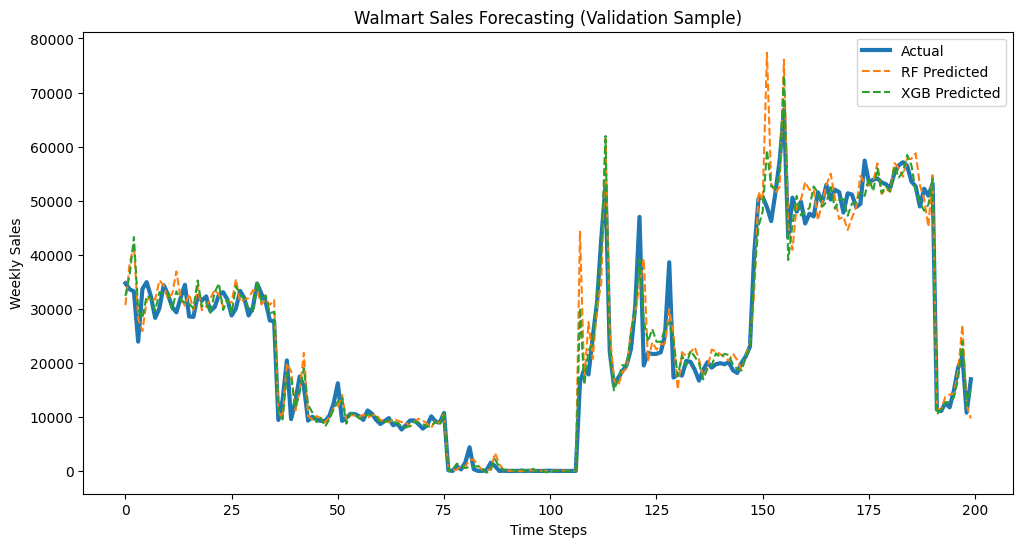

In [44]:
plt.figure(figsize=(12,6))
plt.plot(y_val.values[:200], label="Actual", linewidth=3)
plt.plot(y_pred_rf[:200], label="RF Predicted", linestyle="--")
plt.plot(y_pred_xgb[:200], label="XGB Predicted", linestyle="--")
plt.xlabel("Time Steps")
plt.ylabel("Weekly Sales")
plt.title("Walmart Sales Forecasting (Validation Sample)")
plt.legend()
plt.show()